<a href="https://colab.research.google.com/github/kasvinatirumal/wdrp_wi25/blob/main/Analysis_of_Call_Option_Pricing%2C_Drift_and_Volatility_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Option Pricing for the Top 5 S&P 500 Stocks

Research Questions:
1. Does the volatility smile exist in real-world markets, and how does its curviness change with different times to expiration? Under what market conditions is the volatility smile most pronounced?
1. What would the price of each call option be under risk-neutral valuation, and how does it differ from its actual market price?

In [29]:
pip install yahoo_fin

In [30]:
from yahoo_fin import options
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import math
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [31]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Loading & Preparation

In [32]:
# creates a Ticker object for the top 5 S&P 500 Companies
aapl = yf.Ticker("AAPL") # Apple
nvda = yf.Ticker("NVDA") # NVIDIA
msft = yf.Ticker("MSFT") # Microsoft
amzn = yf.Ticker("AMZN") # Amazon
meta = yf.Ticker("META") # Meta

# gets expiration_dates for options
exp_dates = aapl.options

date_six_month_ltr = datetime.today().replace(month=(datetime.today().month + 6) % 12)
exp_date = next(date for date in exp_dates if date >= date_six_month_ltr.strftime("%Y-%m-%d"))

In [33]:
stocks = ["AAPL", "NVDA", "MSFT", "AMZN", "META"]
calls_df = options.get_calls("AAPL", exp_date)

for stock in stocks[1:]:
    df = options.get_calls(stock, exp_date)
    calls_df = pd.concat([calls_df, df])

In [34]:
calls_df["Trade Date"] = pd.to_datetime(calls_df["Last Trade Date (EST)"], format="%m/%d/%Y %I:%M %p").dt.date
calls_df["Months to Exp"] = ((pd.to_datetime(exp_date) - pd.to_datetime(calls_df["Trade Date"])).dt.days / 30).astype(int)
calls_df["Implied Volatility"] = calls_df["Implied Volatility"].str[:-1].astype(float)/100
calls_df = calls_df[calls_df["Implied Volatility"] != 0]

In [35]:
calls_df = calls_df.reset_index().drop(columns=["index", "Last Trade Date (EST)", "Change", "% Change", "Volume", "Open Interest"])
calls_df.to_csv("call_options.csv", index=False)

In [36]:
calls_df

,Contract Name,Strike,Last Price,Bid,Ask,Implied Volatility,Trade Date,Months to Exp
0,AAPL250919C00135000,135,104.91,112.40,113.25,0.7129,2025-01-14,8
1,AAPL250919C00145000,145,113.95,95.30,96.45,0.2607,2024-12-27,8
2,AAPL250919C00245000,245,17.58,0.00,0.00,0.0039,2025-02-28,6
3,AAPL250919C00250000,250,15.98,0.00,0.00,0.0078,2025-02-28,6
4,AAPL250919C00255000,255,13.85,0.00,0.00,0.0156,2025-02-28,6
...,...,...,...,...,...,...,...,...
299,META250919C01320000,1320,0.70,0.00,0.00,0.1250,2025-02-24,6
300,META250919C01330000,1330,0.71,0.00,0.00,0.1250,2025-02-24,6
301,META250919C01340000,1340,1.85,0.57,0.79,0.3938,2025-01-30,7
302,META250919C01350000,1350,0.72,0.00,0.00,0.1250,2025-02-26,6


In [37]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Contract Name       304 non-null    object 
 1   Strike              304 non-null    int64  
 2   Last Price          304 non-null    float64
 3   Bid                 304 non-null    float64
 4   Ask                 304 non-null    float64
 5   Implied Volatility  304 non-null    float64
 6   Trade Date          304 non-null    object 
 7   Months to Exp       304 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 19.1+ KB


In [38]:
calls_df.describe()

,Strike,Last Price,Bid,Ask,Implied Volatility,Months to Exp
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,615.661184,34.615921,29.495164,29.892796,0.472151,6.776316
std,524.891188,82.439169,100.388881,101.217810,1.148435,2.203200
min,15.000000,0.100000,0.000000,0.000000,0.001000,6.000000
25%,235.000000,1.407500,0.000000,0.000000,0.062500,6.000000
50%,462.500000,6.250000,0.000000,0.000000,0.125000,6.000000
75%,816.250000,25.037500,0.000000,0.000000,0.125000,6.000000
max,2500.000000,568.620000,665.450000,668.650000,7.279300,15.000000


### RQ1: Does the volatility smile exist in real-world markets, and how does its curviness change with different times to expiration? Under what market conditions is the volatility smile most pronounced?

In [39]:
calls_df["Months to Exp"].value_counts()

,count
Months to Exp,
6,241
7,26
15,19
8,16
10,1
9,1


In [40]:
calls_df_plot = calls_df[~calls_df["Months to Exp"].isin([9, 10])]

In [41]:
groups = calls_df_plot.groupby("Months to Exp")
groups.get_group(15).head()

,Contract Name,Strike,Last Price,Bid,Ask,Implied Volatility,Trade Date,Months to Exp
26,NVDA250919C00044000,44,89.05,87.80,91.90,1.6614,2024-06-13,15
99,NVDA250919C01950000,1950,99.00,99.05,101.50,5.0620,2024-06-07,15
100,NVDA250919C02000000,2000,92.10,92.35,94.95,4.7581,2024-06-07,15
101,NVDA250919C02050000,2050,88.60,86.10,88.80,4.5158,2024-06-05,15
102,NVDA250919C02100000,2100,81.00,80.85,83.15,4.3267,2024-06-07,15


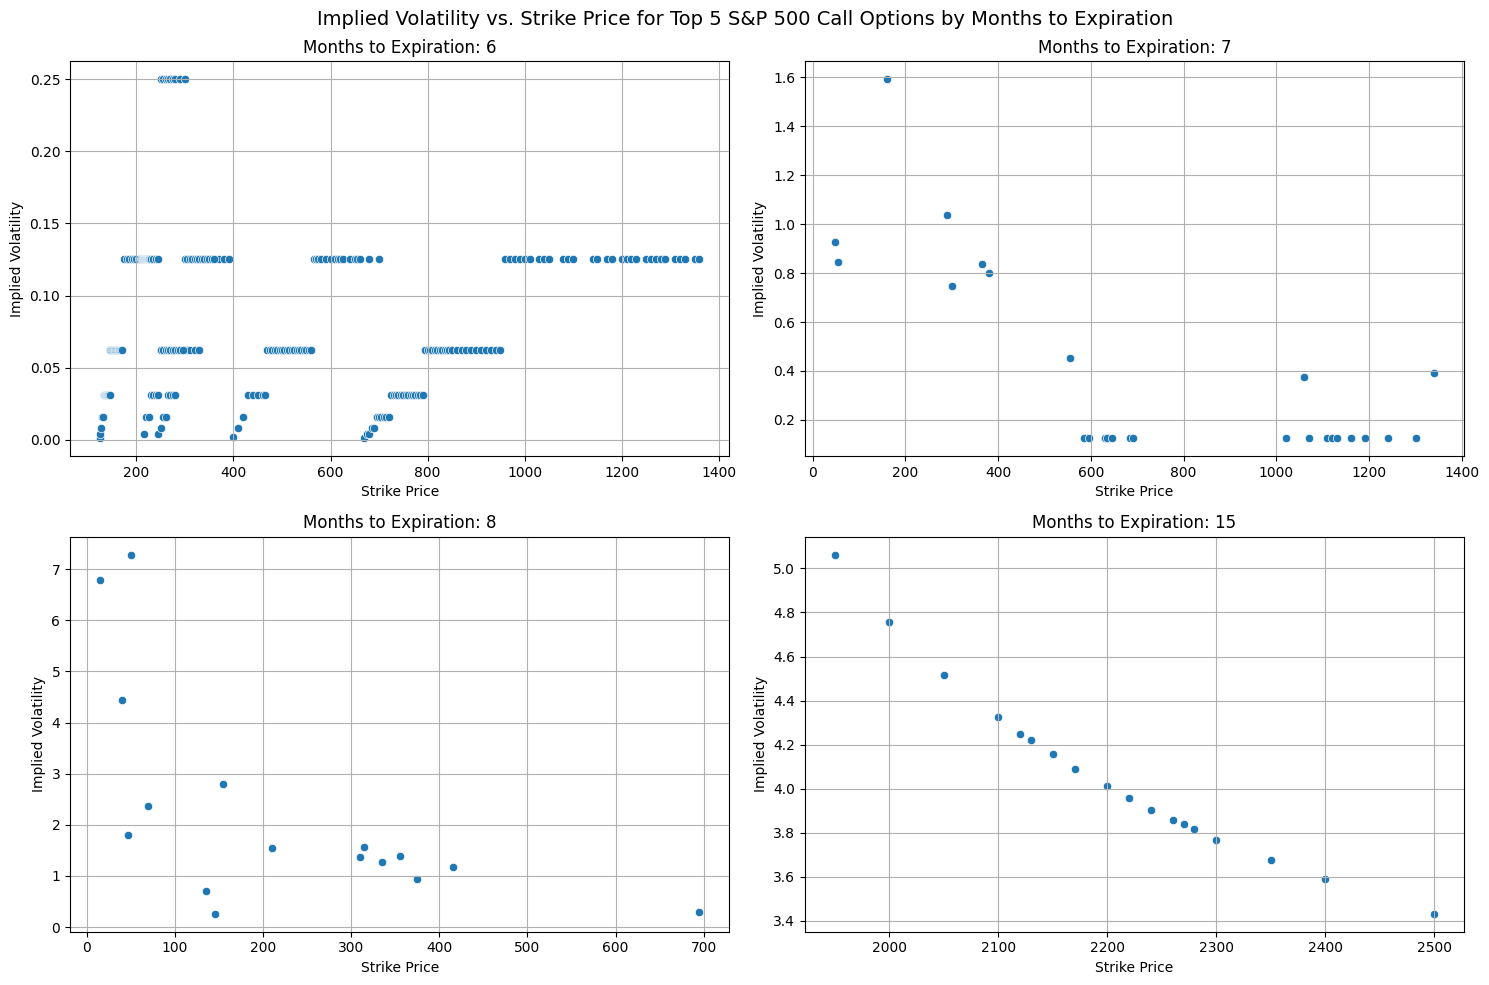

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Implied Volatility vs. Strike Price for Top 5 S&P 500 Call Options by Months to Expiration", fontsize=14)

axes = axes.flatten()
for ax, (month, group) in zip(axes, groups):
    if month == 15:
        group = group.iloc[1:]  # remove outlier to zoom into the visual
    sns.scatterplot(ax=ax, x="Strike", y="Implied Volatility", data=group)
    ax.set_title(f"Months to Expiration: {month}")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True)
plt.tight_layout()

The further away an option is from expiring, the more the shape of the scatterplots resemble a volatility smile.









### RQ2: What would the price of each call option be under risk-neutral valuation, and how does it differ from its actual market price?

The formula for risk-neutral valuation for European call options is known as **Black-Scholes Formula**, which states: The price of a European Call Option wth strike price $K$ and time of maturity $T$ is given by the formula $\Pi(t) = F(t, S(t))$, where: \\

$$F =  S \cdot N[d_1(t, s)] - e^{−r(T-t)} \cdot K \cdot N[d_2(t, s)]$$

$N$ is the cumulative distribution function for the $N[0,1]$ distribution, and: \\
\begin{align*}
d_1(t, s) &= \frac{1}{\sigma \cdot \sqrt{T-t}} \cdot \left[ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right) \cdot (T-t)\right]\\
\\
d_2(t, s) &= d_1(t, s) - \sigma \cdot \sqrt{T-t}
\end{align*}

The variables above are as follows:
- $K$: Strike price in US dollars
- $S$: Stock price in US dollars
- $T-t$: Time to expiration in number of years
- $r$: Risk-free rate (based on return on US treasury bills)
- $\sigma$: Implied volatility
- $F$: Final price of option

Using the above formula, we calculate the theorectical price for each call option in the dataset `calls_df`

In [43]:
def calc_call_option_price(S, K, T, r, v):
  d1 = (math.log(S/K) + (r + 0.5 * v**2) * T) / (v * math.sqrt(T))
  d2 = d1 - v * math.sqrt(T)
  F = S * norm.cdf(d1) - math.exp(-r * T) * K * norm.cdf(d2)
  return F

In [44]:
def get_monthly_stock_data(ticker, trade_date):
    year_month = trade_date.strftime("%Y-%m")

    # Download monthly stock data
    stock_data = yf.download(ticker, start=f'{year_month}-01', end=f'{year_month}-28', interval='1mo', progress=False, auto_adjust=True)

    if not stock_data.empty:
        return stock_data["Close"].iloc[-1]  # Last trading day of the month
    else:
        return None

In [45]:
stock_prices = []
for index, row in calls_df.iterrows():
    ticker = row["Contract Name"][:4] # gets first 4 characters
    trade_date = row["Trade Date"]

    price = get_monthly_stock_data(ticker, trade_date)[ticker]
    stock_prices.append(price)

calls_df["Stock Price"] = stock_prices.copy()

In [46]:
r_discrete = 0.0434
r_cont = 2 * math.log(1+r_discrete/2)

In [47]:
calls_df["Risk Neutral Price"] = calls_df.apply(
    lambda row: calc_call_option_price(row["Stock Price"], row["Strike"], row["Months to Exp"] / 12, r_cont, row["Implied Volatility"]), axis=1
)
calls_df["Market Price"] = (calls_df["Bid"] + calls_df["Ask"]) / 2
calls_df["Difference"] = calls_df["Risk Neutral Price"] - calls_df["Market Price"]

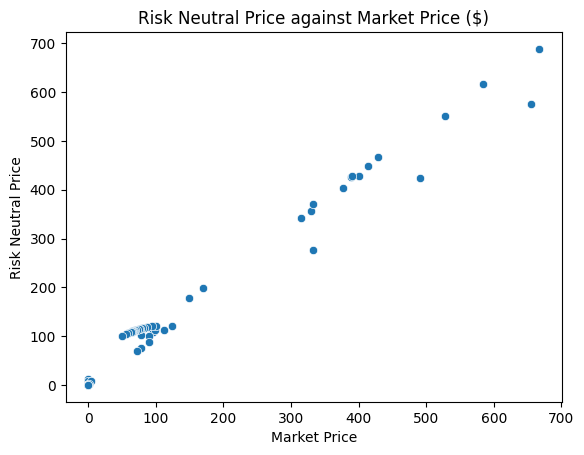

In [48]:
sns.scatterplot(x="Market Price", y="Risk Neutral Price", data=calls_df)
plt.title("Risk Neutral Price against Market Price ($)");

In [49]:
calls_df["Price Valuation"] = np.where(
    calls_df["Difference"] > 0, "Underpriced",
    np.where(
        calls_df["Difference"] < 0, "Overpriced", "Fairly Priced"
    )
)

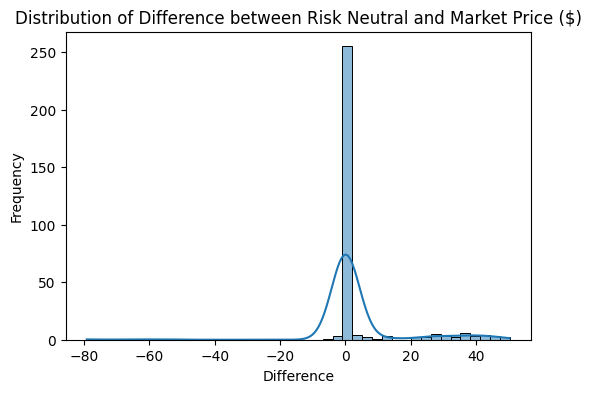

In [50]:
plt.figure(figsize=(6, 4))
sns.histplot(calls_df["Difference"], binwidth=3, kde=True)
plt.title("Distribution of Difference between Risk Neutral and Market Price ($)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()

In [51]:
def median_diff_by_col(df, col):
  unique_cat = calls_df[col].value_counts()
  median_diff = calls_df.groupby(col)["Difference"].median()
  median_diff_by_cat = pd.DataFrame({
      'Count': unique_cat,
      'Median Difference($)': median_diff
  })
  return median_diff_by_cat


md_price_val = median_diff_by_col(calls_df, "Price Valuation")

In [52]:
total = md_price_val["Count"].sum()
md_price_val["Percentage (%)"] = md_price_val["Count"] / total * 100
md_price_val

,Count,Median Difference($),Percentage (%)
Price Valuation,,,
Overpriced,8,-3.888757,2.631579
Underpriced,296,0.000011,97.368421


Most call options within the dataset was underpriced.

In [53]:
md_months = median_diff_by_col(calls_df, "Months to Exp")
md_months

,Count,Median Difference($)
Months to Exp,,
6,241,0.000003
7,26,0.000017
8,16,17.518113
9,1,6.083757
10,1,14.037526
15,19,40.859862


As the time to expiration increases, the deviation between risk-neutral price and market price also increases.

# Estimating Drift and Historic Volatility of Microsoft Stock in 2024

In [54]:
ticker = "MSFT"
mfst_info = yf.download(ticker, start="2024-01-01", end="2024-12-31", progress=False)
mfst_price = mfst_info['Close'].reset_index()
mfst_price.columns = ['Date', 'Close']

We will use the **Geometric Brownian Motion (GBM)** model to represent the stochastic process of stock prices. Under this model, let $X_t$ denote our stock price at time $t$, and the process $Z_t$ is defined as follows: $Z_t = ln(X_t)$.

The process $Z_t$ follows a normal distribution with the following properties:
$$
Z_{\frac{i+1}{251}} - Z_{\frac{i}{251}} \sim N \left(\alpha - \frac{1}{2}\sigma^2\cdot\frac{1}{251}, \ \frac{\sigma^2}{251} \right)
$$
where $\alpha$ is the drift term, and $\sigma$ the volatility.

We use 251 trading days instead of 365, since we only 251 trading days in 2024.


In [55]:
msft_stock = mfst_price
msft_stock['log_returns'] = np.log(msft_stock['Close']) - np.log(msft_stock['Close'].shift(1))
msft_stock

,Date,Close,log_returns
0,2024-01-02,367.380585,NaN
1,2024-01-03,367.113190,-0.000728
2,2024-01-04,364.478180,-0.007204
3,2024-01-05,364.289978,-0.000516
4,2024-01-08,371.164673,0.018696
...,...,...,...
246,2024-12-23,434.379028,-0.003097
247,2024-12-24,438.450836,0.009330
248,2024-12-26,437.233276,-0.002781
249,2024-12-27,429.668457,-0.017453


In [56]:
drift_daily = msft_stock["log_returns"].mean()
vol_daily = msft_stock["log_returns"].std()

annual_drift = drift_daily + (0.5 * vol_daily**2) / 251
annual_vol = vol_daily * np.sqrt(251)

print("Estimated Annualized Values for 2024:")
print(f"Drift (Expected Return): {annual_drift}")
print(f"Historic Volatility: {annual_vol}")

Estimated Annualized Values for 2024:
Drift (Expected Return): 0.0005734691737124808
Historic Volatility: 0.20038467279720662
